# Generalized linear models 1: Exponential growth

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In this session we will understand:
- how to build the exponential model for populaton growth and transform it to a linear model
- how to maximum likelihood inference with linear models using gradient descent
- how to perform Bayesian inference with linear models using `emcee`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import seaborn as sns
sns.set_context('talk')
red, blue, green = sns.color_palette('Set1', 3)

# Data: World Bank

Our focus today will be on modeling population growth. 
We will start with human populations and use data from the [World Bank](http://www.worldbank.org/) on the [population size of countries](http://data.worldbank.org/indicator/SP.POP.TOTL) around the world from 1960 until 2021.

In [2]:
df = pd.read_csv('../data/world_growth_2021.csv')
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,...,552530654.0,567891875.0,583650827.0,600008150.0,616377331.0,632746296.0,649756874.0,667242712.0,685112705.0,702976832.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,...,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,...,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,...,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0


We now want to **tidy our data** - transform the dataset to a **DataFrame** format:

> Tidy datasets are easy to manipulate, model and visualize, and have a specific structure: each variable is a column, each observation is a row, and each type of observational unit is a table - [Hadley Wickham (2014), _Tidy Data_, J. Stat. Soft.](http://www.jstatsoft.org/v59/i10)


This means that every row in the table has exactly one measurement - population size - with all the relevant variables - country name and year.
Read more on [tidy data](http://www.jstatsoft.org/v59/i10).

We do this using Pandas' `melt` function: 

In [3]:
print(df.shape)
df = pd.melt(
    df, 
    id_vars=('Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'), 
    var_name='Year', 
    value_name='Population'
)
print(df.shape)
df.head()

(266, 66)
(16492, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54608.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,1960,130692579.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8622466.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,1960,97256290.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5357195.0


In [4]:
df.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
16487,Kosovo,XKX,"Population, total",SP.POP.TOTL,2021,1786038.0
16488,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,2021,32981641.0
16489,South Africa,ZAF,"Population, total",SP.POP.TOTL,2021,59392255.0
16490,Zambia,ZMB,"Population, total",SP.POP.TOTL,2021,19473125.0
16491,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,2021,15993524.0


We get rid of rows that have `NA` values:

In [5]:
print(df.shape)
df.dropna(axis=0, inplace=True)
print(df.shape)
df.head()

(16492, 6)
(16400, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Population
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54608.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,1960,130692579.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,1960,8622466.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,1960,97256290.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,1960,5357195.0


Note that the `Year` column has a type `O` (object) instead of `int`, so we change that:

In [6]:
print('Year', df['Year'].dtype, 'Population', df['Population'].dtype)
df['Year'] = df['Year'].astype(int)
print('Year', df['Year'].dtype, 'Population', df['Population'].dtype)

Year object Population float64
Year int64 Population float64


To get an idea of how the data looks like, let's start with Israel and some other small developed countries.
We will plot their population size over time.

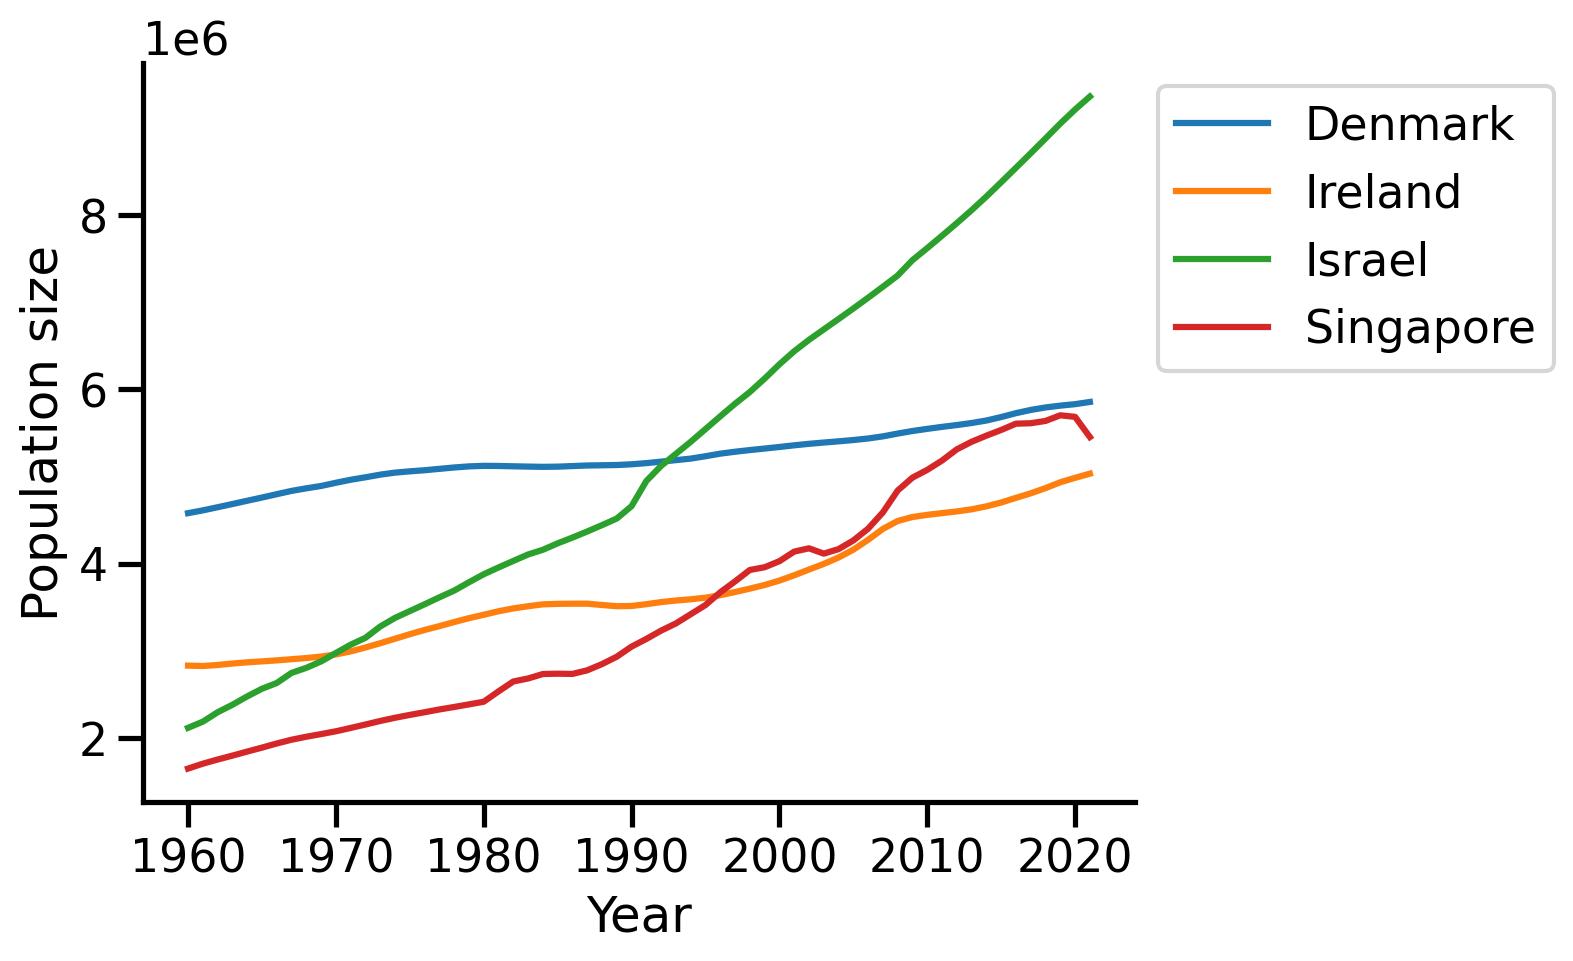

In [7]:
countries = 'Israel', 'Denmark', 'Singapore', 'Ireland'
countries_mask = df['Country Name'].isin(countries)
df_countries = df[countries_mask]

fig, ax = plt.subplots()
df_countries.groupby('Country Name', sort=True).plot('Year', 'Population', ax=ax)
ax.legend(sorted(countries), bbox_to_anchor=(1, 1))
ax.set_ylabel('Population size')
sns.despine()

# Exponential growth model

How do we model the growth of a population?

According to [Malthus](http://en.wikipedia.org/wiki/Thomas_Robert_Malthus), if the instantaneous rate of births is $b$ and the instantaneous rate of deaths is $r$, then the instantaneous rate of growth (or decline) of the population is

$$
\frac{dN(t)}{dt} = b N(t) - d N(t) = r N(t)
$$

where $N(t)$ is the population size at time $t$ and $r=b-d$ is the specific growth rate (or per capita growth rate).

This is called the Malthusian growth model or more commonly the [exponential growth model](https://en.wikipedia.org/wiki/Exponential_growth).

This ODE can be solved via [logarithmic differentiation](https://en.wikipedia.org/wiki/Logarithmic_differentiation):

$$
\frac{dN(t)}{dt} = r N(t) \Rightarrow \\
\frac{1}{N(t)} \frac{dN(t)}{dt} = r \Rightarrow \\
\frac{d \log{N(t)}}{dt} = r \Rightarrow \\
\log{N(t)} =  r t + C \Rightarrow \\
N(t) = e^{rt + C} = e^{rt} e^{C}
$$

Now add the boundary condition $N(0) = N_0$ to get

$$
e^{C} = N_0
$$

and finally

$$
N(t) = N(0) e^{rt}
$$

Note that during the integration we found that the **logarithm of the population should be a linear function of time** $\log{N(t)} = \log{N(0)} + rt$.

Let's check if the world population growth fits the exponential model. 
First define a new column for the log of the population size:

In [17]:
df['LogPopulation'] = np.log10(df['Population'])

If we write $y(t) = \log N(t)$, we can model the log of the population size as
$$
\widehat{y} = rt + y_0
$$
where here $t$ is the number of year since the first year in the dataset, 1960.

Remember, the model parameters can be interpreted as follows:
- the "intercept" $y_0$ is the estimate for log size in year zero, and
- the "slope" $r$ is the estimate for the specific growth rate.

Let's get the time and log population for Israel as an example.
We change $t$ to start at zero rather than 1960, and we get the NumPy array from the Pandas dataframe.

In [18]:
idx = df['Country Name']=='Israel'
t = df.loc[idx, 'Year'] 
t -= t.min()
t = t.values
y = df.loc[idx, 'LogPopulation'].values

We can then calculate the expected outcome $\widehat{y}$ and the [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals), $y - \widehat{y}$, which are the differences between the observations and the expectations.

A reasonalbe first guess is to set $y_0$ to the minimal observed value, and $r$ to the average difference between consecutive observations, $y(t+1)-y(t)$.

y0 = 6.33, r = 0.01


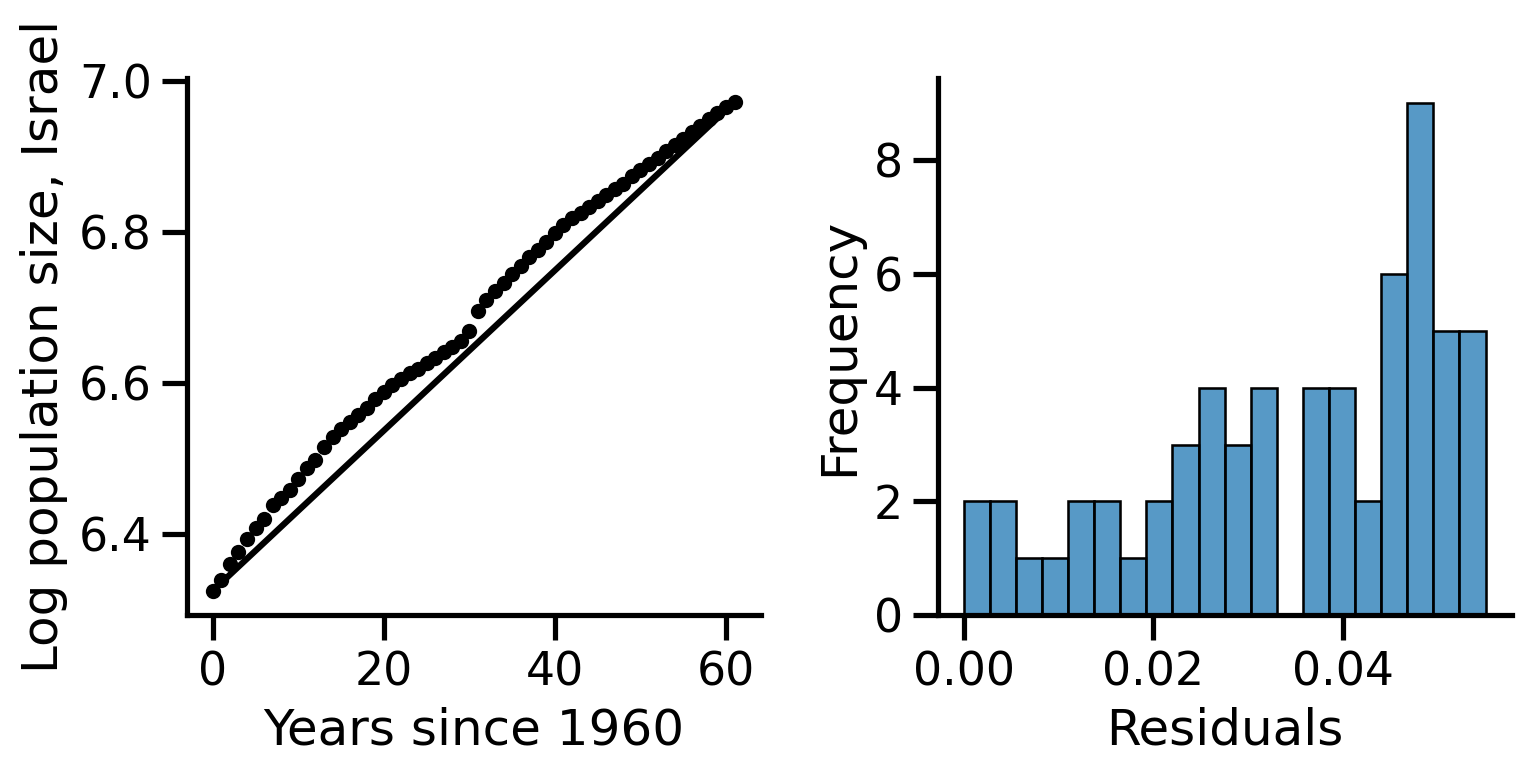

In [19]:
y0 = y.min()
r = (y[1:] - y[:-1]).mean()
print("y0 = {:.2f}, r = {:.2f}".format(y0, r))

yhat = r * t +  y0
residuals = y - yhat

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
ax.plot(t, y, '.k')
ax.plot(t, yhat, color='k')
ax.set_xlabel('Years since 1960')
ax.set_ylabel('Log population size, Israel')

ax = axes[1]
sns.histplot(residuals, bins=20, ax=ax)
ax.set(xlabel='Residuals', ylabel='Frequency')

fig.tight_layout()
sns.despine();

For this first-guess model we see that most all of the markers are above the line, and the residuals are all positive, which means that our model predictions $\widehat{y}$ are lower than the observed values $y$: that is, our model is an under-estimation.

How do we proceed to find suitable model parameters $r$ and $y_0$?

# Maximum likelihood & least squares

The exponential growth model above means that the log population size is a linear function of time. 
In the simplest form of linear model, we assume that the data ($y$) has a [normal (or Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) around the linear estimator ($\widehat{y})$.

Note that this assumption is often invalid, and the framework of _generalized linear models_ allow us to replace the normal distribution with other distributions.
We'll talk about it again later.

Usually, when we speak about probabilities, we ask **"what is the probability to see this data given this model"** - when I say "model" I mean something like 
$$
\widehat{y} = rt+y_0
$$
with given values for $r$ and $y_0$, such as $r=1$ and $y_0=0$, and a normal distribution of observed values around the expected value,
$$
y \sim \mathit{Normal}(\widehat{y}, \sigma^2)
$$
where $\sigma^2$ is the variance of the normal distribution.

That is, we want to say something about how the observed data is expected to be dispersed given a specific model.

In general, the probability density function for an observed value $y$ is defined by the normal distribution as
$$
\phi(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(y-\widehat{y})^2}{2\sigma^2}\bigg).
$$

So, for example, given this model ($r=2, y_0=0 \Rightarrow y=2t$), if $t=1$ then the probability for $y=2.5$ is:
$$
\phi(8) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(2.5 - 2)^2}{2\sigma^2}\bigg).
$$

Now, we are ready to find $r$ and $y_0$, and this is where *likelihood* comes into place, and its definition is straight-forward:

**The likelihood of the model 
$$
y \sim N(\widehat{y}=rt+y_0, \sigma)
$$
given observed data $\{(t_i, y_i)\}_i$ is the probability of seeing data given the model.**

If we have mutliple data points (we do!) we can just multiply all of them under the assumption that each data point (here, game, so... not sure that we can do this) is *independent* (in the probability sense of independence, that is, knowing what happened in one of them doesn't change the probability of the other one occuring).

So the likelihood of the model $y \sim Normal(\widehat{y}=rt+y_0, \sigma^2)$ given data points $\{(x_i, y_i)\}_i$, is

$$
\mathcal{L}(a,b | \{(x_i, y_i)\}) = (2 \pi \sigma^2)^{-n/2} \prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i-rt_i-y_0)^2}{2\sigma^2}\bigg)}
$$

After establishing what likelihood is, we can ask _"what are the parameters $r$ and $y_0$ that maximize the model likelihood"_. 
This is akin to asking what are the $r$ and $y_0$ values for which the probability of seeing the data we saw is maximized.
This approach is called **maximum likelihood**.

Now, our likelihood $\mathcal{L}$ is a product of exponents, so we can take the log-likelihood (literally the log of the likelihood) to get a simpler expression
$$
\log\mathcal{L} = \\
\log (2 \pi \sigma^2)^{-n/2} + \log{\prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i-rt_i-y_0)^2}{2\sigma^2}\bigg)}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} + \sum_{i=1}^{n}{-\frac{(y_i-rt_i-y_0)^2}{2\sigma^2}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} - \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(y_i-rt_i-y_0)^2}
$$

Note that 
- $\log{\mathcal{L}}$ is an increasing function of $\mathcal{L}$ so maximizing the log-likelihood is equivalent to maximizing the likelihood
- $a$ and $b$ only appear in the sum-of-squares, which is prepended by a negative sign, so minimizing the sum-of-squares is equivalent to maximizing the log-likelihood
- if we only care about the best estimate of $r$ and $y_0$ then we don't really care about the variance $\sigma^2$ (we would care if we wanted to have some statistical measure of precision or confidence)

This is where the **least squares** approach comes from -- when assuming a model with normal distribution of residuals, maximizing the likelihood is equivalent to minimizing the sum-of-squares of the residuals, or the differences between the model expected values $\widehat{y}$ and the observed values $y$.
Note that this works with non-linear models just the same, as long as the residuals are normally and independently distributed.

In tihs case of a linear model there is a formula to find the maximum likelihood values of $r$ and $y_0$.
But not in every case there is such a formula, so let's continue as if there is no formula.

Let's calculate the sum-of-squares. 
Note that Pandas aggregation methods (such as `sum` or `mean`) ignore NaN values, but this is not always the case in other numerical packages.

In [11]:
def sumsquares(r, y0, t, y):
    yhat = r * t +  y0
    residuals = y - yhat
    residuals = yhat - y
    return (residuals*residuals).sum()

sumsquares(r, y0, t, y)

0.08887322432095048

Now we would like to find $r$ and $y_0$ that minimize the function `sumsquares`.

# Gradient descent

One way to do this is with *gradient descent*.
This is an iterative algorithm.
In each step, we calculate that gradient of the RSS function respect to $r$ and $y_0$ (the gradient is just the vector of derivatives):
$$
RSS(a,b,x,y) = \sum_{i=1}^{n}{(y_i-rt_i-y_0)^2} \\
\frac{\partial RSS}{\partial r} = 2\sum_{i=1}^{n}{rt_i^2 + t_iy_0 - t_iy_i} \\
\frac{\partial RSS}{\partial y_0} = 2\sum_{i=1}^{n}{rt_i + y_0 - y_i} \\
$$

We then "descend" (minimize) the function just a tiny bit by updating $r$ and $y_0$ in the oppositve direction of the gradient:
$$
r(k) = r(k-1) - \eta \frac{\partial SS}{\partial r}  \\ 
y_0(k) = y_0(k-1) - \eta \frac{\partial SS}{\partial y_0} \\ 
$$
where $\eta$ is the size of the step we take (the "tiny bit"), also sometimes called the *learning rate*. We'll talk later about methods in which this rate can be learned or adjusted over time.

**Home exercise**: Verify our calculation of $\frac{\partial RSS}{\partial r}$ and $\frac{\partial RSS}{\partial y_0}$.

In [12]:
def gradient_descent(r, y0, t, y, η=0.00001):
    dr  = (2*r*t*t + 2*t*y0 - 2*t*y).sum()
    dy0 = (2*r*t + 2*y0 - 2*y).sum()
    return r - η * dr, y0 - η * dy0

The last technical details is the stopping condition.
We can set the gradient descent to stop when the relative difference between the sum of squares of two iterations is less than some value, or when the change in parameters from one iteration to the next is smaller than some value. But we will just set it to run for a fixed number of iterations.

In [13]:
def fit_model(t, y, r=0, y0=0, iters=30000, verbose=True):    
    for k in range(iters+1):
        r, y0 = gradient_descent(r, y0, t, y)
        if k % (iters//10) == 0:
            RSS = sumsquares(r, y0, t, y)
            if verbose: 
                print("{:5d}: RSS={:.6f},\tr={:.4f},\ty0={:.4f}".format(k, RSS, r, y0))
    return r, y0

In [14]:
θhat = fit_model(t, y)

    0: RSS=1289.952690,	r=0.2568,	y0=0.0083
 3000: RSS=95.688262,	r=0.0702,	y0=3.9129
 6000: RSS=14.258666,	r=0.0334,	y0=5.4204
 9000: RSS=2.134463,	r=0.0193,	y0=6.0021
12000: RSS=0.329268,	r=0.0138,	y0=6.2266
15000: RSS=0.060489,	r=0.0117,	y0=6.3132
18000: RSS=0.020470,	r=0.0108,	y0=6.3466
21000: RSS=0.014511,	r=0.0105,	y0=6.3595
24000: RSS=0.013624,	r=0.0104,	y0=6.3645
27000: RSS=0.013492,	r=0.0104,	y0=6.3664
30000: RSS=0.013472,	r=0.0103,	y0=6.3672


Note that there are more efficient ways to find the maximum likelihood, for example using `scipy.optimize.fmin`:

In [15]:
def loss(θ, t, y):
    r, y0 = θ
    return sumsquares(r, y0, t, y)

θhat = scipy.optimize.fmin(
    loss, # loss function to minimize
    (r, y0), # guess
    args=(t, y) # arguments to loss function
)
print("RSS={:.6f},\tr={:.4f},\ty0={:.4f}".format(sumsquares(*θhat, t, y), *θhat))

Optimization terminated successfully.
         Current function value: 0.013469
         Iterations: 27
         Function evaluations: 54
RSS=0.013469,	r=0.0103,	y0=6.3677


## Plot and interpret a linear model

Let's plot the results.
We plot a straight line over the scatterplot.
Note that we sort the x values first otherwise the straight line will zigzag over the plot.

r=0.010, y0=6.368


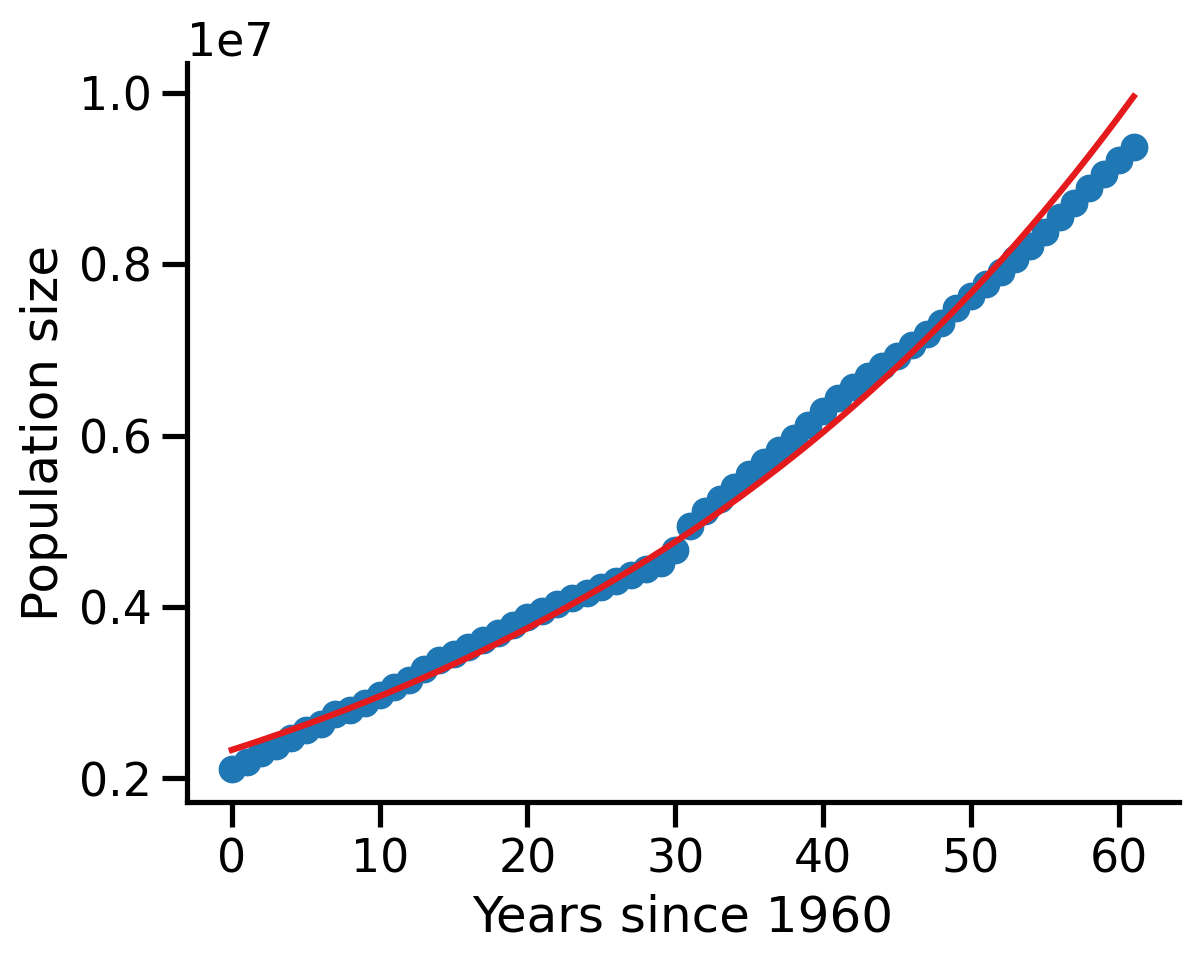

In [16]:
def plot_model(θ, t, y, color=red):
    r, y0 = θ
    yhat = r * t + y0
    plt.plot(t,10** y, 'o')
    plt.plot(t, 10**yhat, '-', color=color)
    plt.xlabel('Years since 1960')
    plt.ylabel('Population size')
    sns.despine()
    print("r={:.3f}, y0={:.3f}".format(r, y0))
    
plot_model(θhat, t, y)

The results can be interpreted as follows
- in year 1960, the population size was $10^6.638$.
- in every year, the population sizes multiplies by $exp(0.01) \approx 1.01$, that is, increases by 1%.

This model will probably do a good job at *interpolation*, that is estimating $\widehat{y}$ for $x$ values that are within the original $x$ values, but not at *extrapolation*: indeed you can see that it over-estimates both at time zero and at the last time point.

# Plot with Seaborn

Seaborn has a function, `lmplot`, to automatically generate linear model plots.

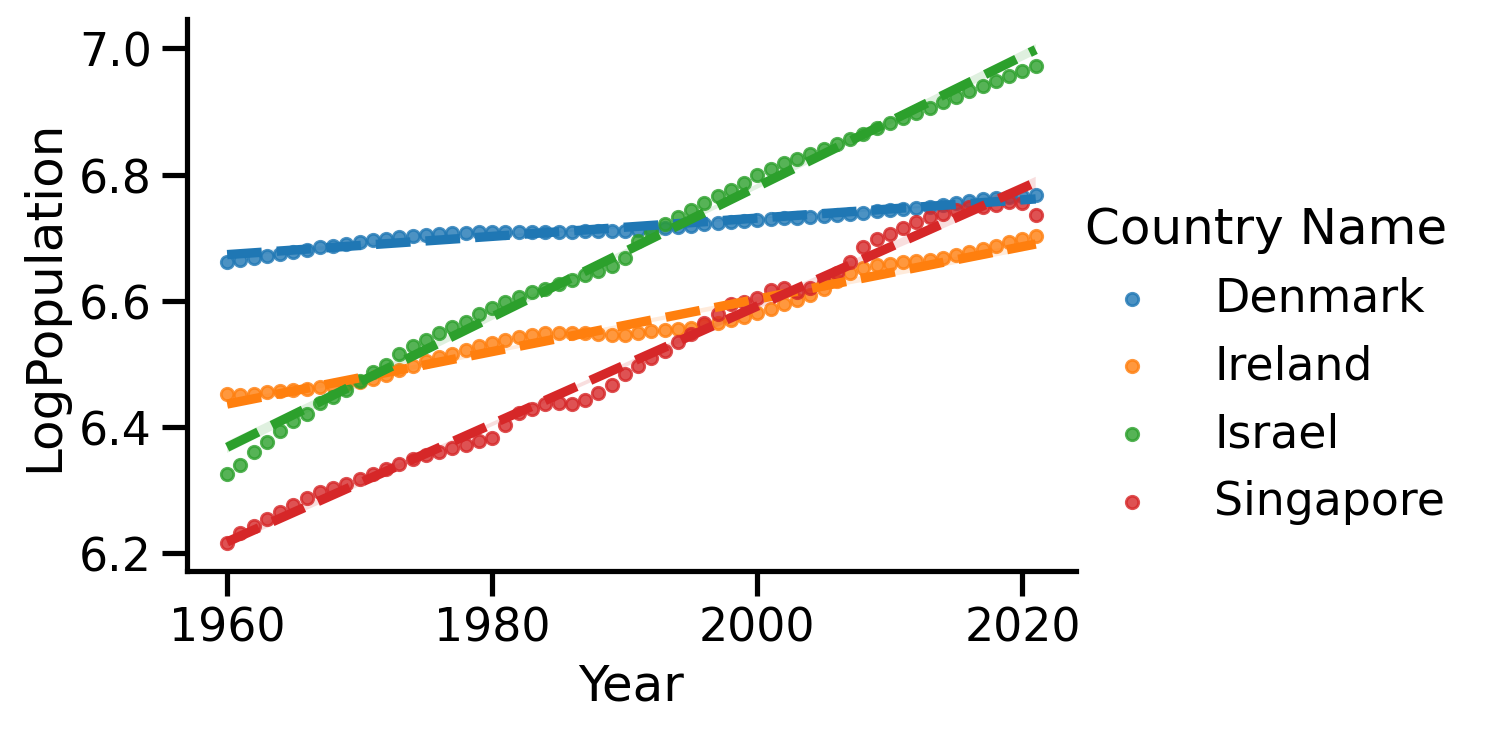

In [17]:
df_countries = df[countries_mask]
sns.lmplot(
    x='Year', 
    y='LogPopulation', 
    hue='Country Name', 
    data=df_countries, 
    height=4, 
    aspect=1.5, 
    line_kws=dict(ls='--'),
    scatter_kws=dict(s=20),
);

What about the G7 countries?

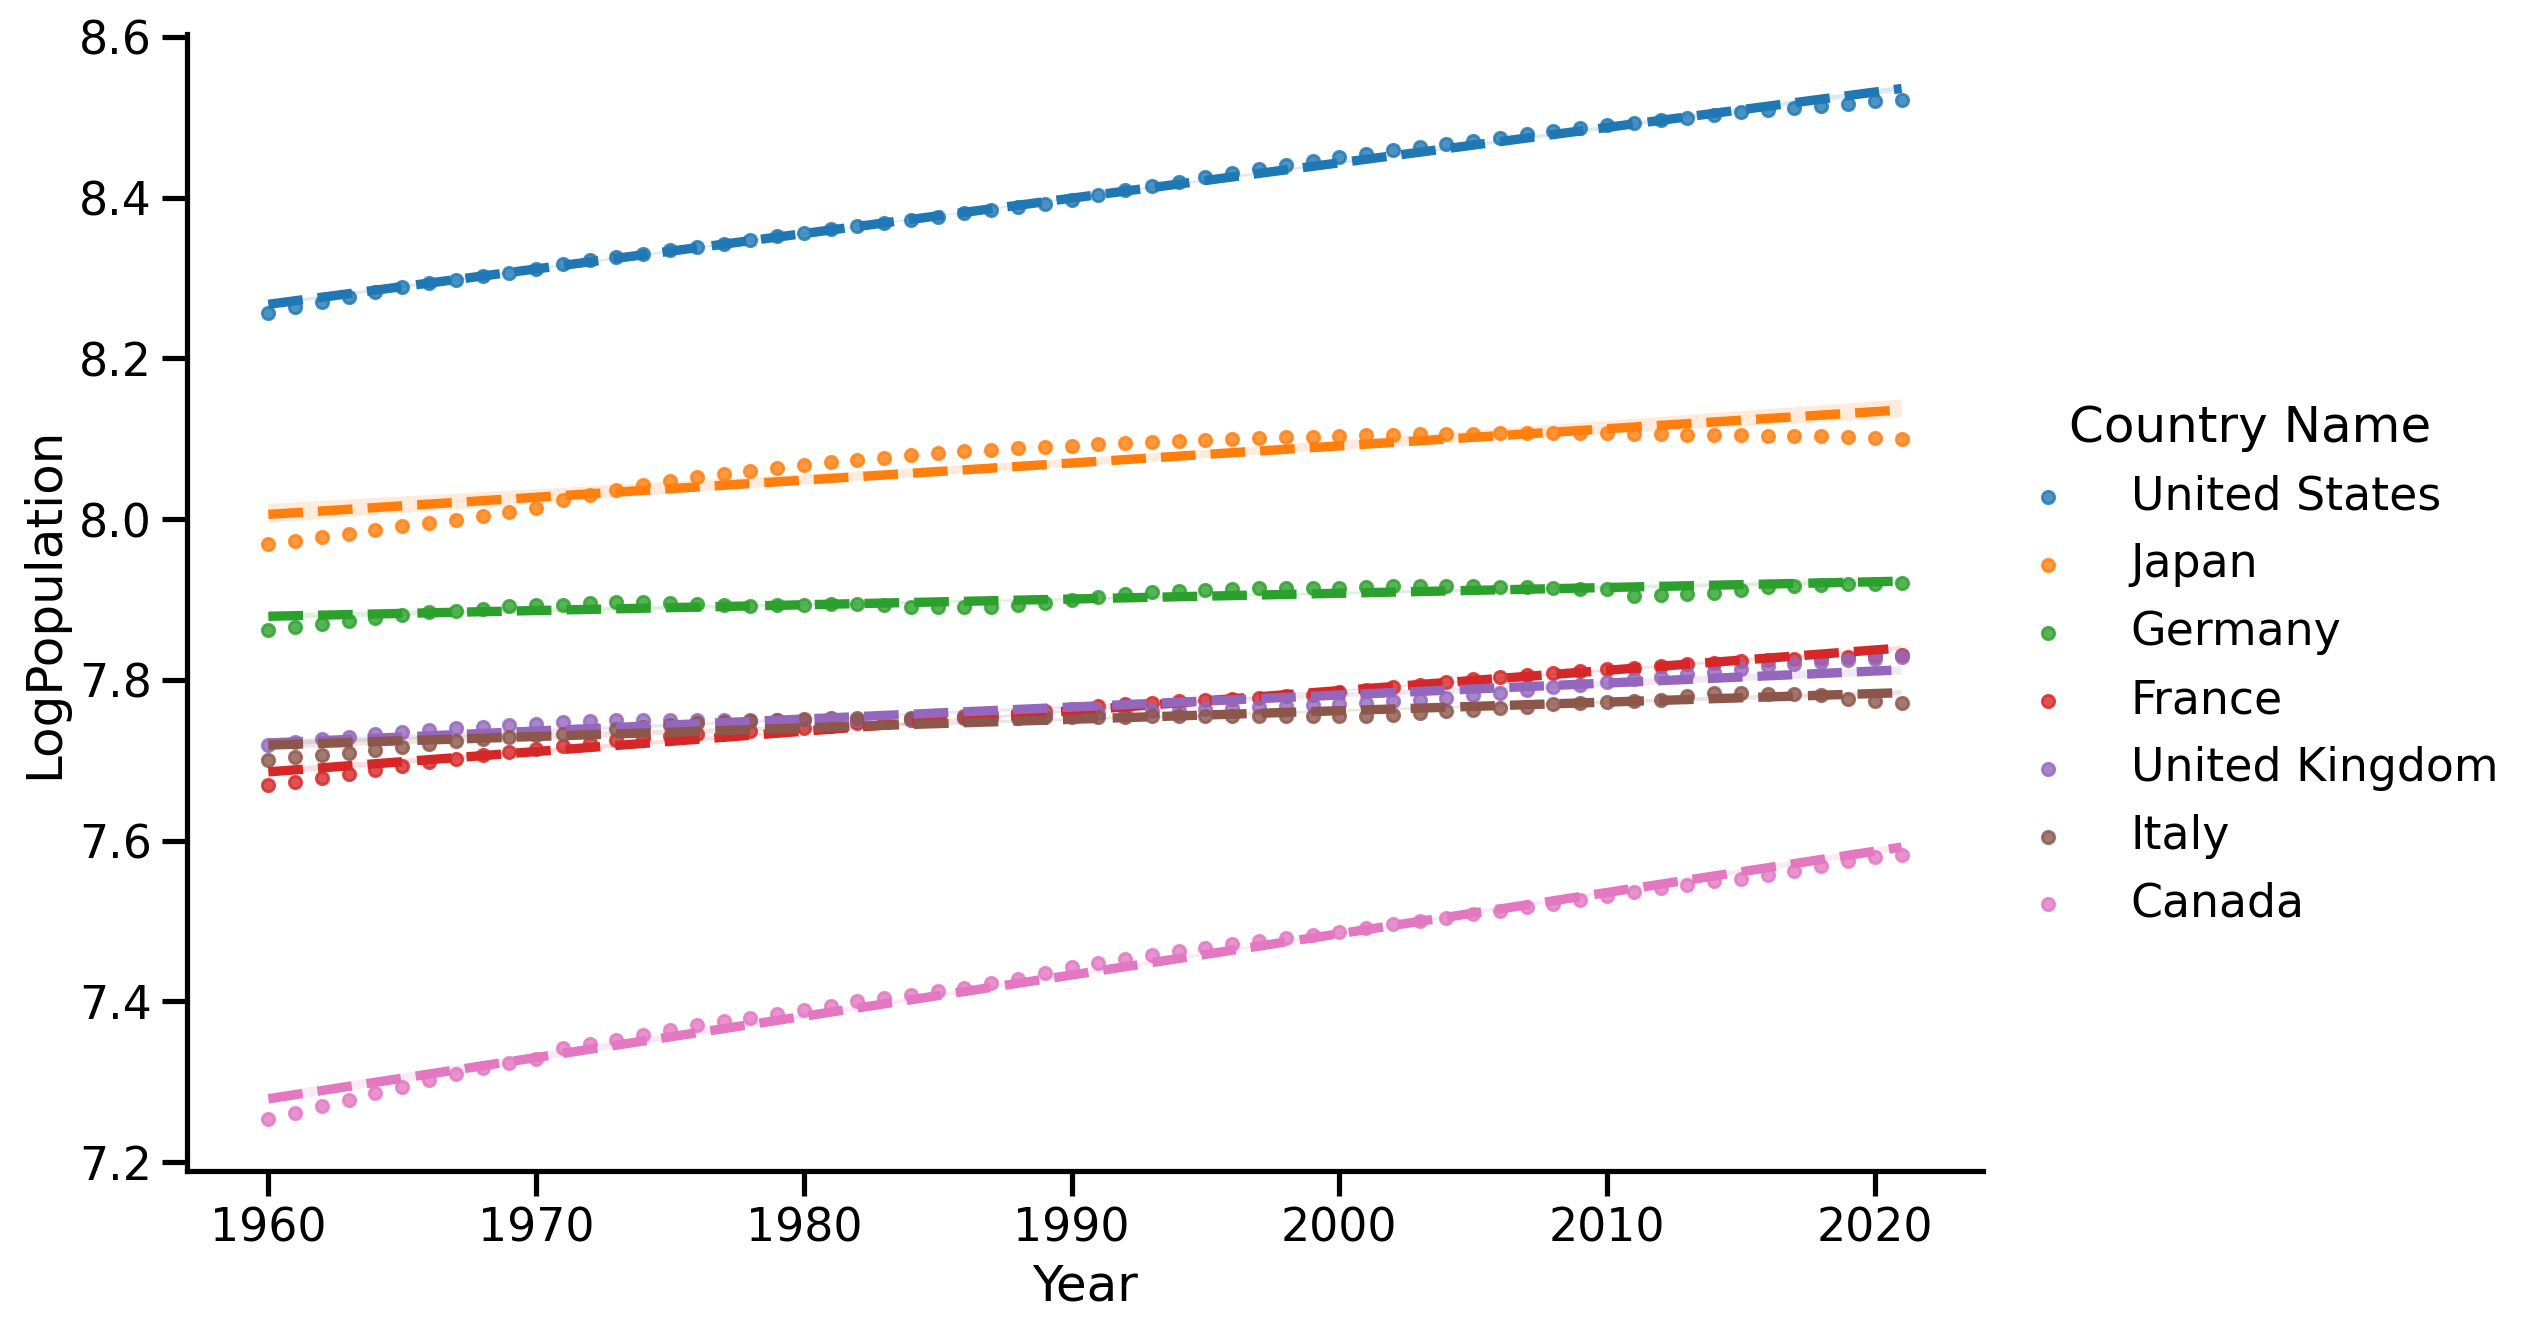

In [18]:
G7_countries = ('Canada', 'France', 'Germany', 
                'Italy', 'Japan', 'United Kingdom', 
                'United States')
G7_mask = df['Country Name'].isin(G7_countries)
G7 = df[G7_mask]
G7_max = G7.groupby('Country Name')['Population'].max() # split-apply-combine
G7_max.sort_values(ascending=False, inplace=True)

sns.lmplot(
    x='Year', 
    y='LogPopulation', 
    hue='Country Name', 
    data=G7, 
    height=7, 
    aspect=1.5, 
    line_kws=dict(ls='--'),
    scatter_kws=dict(s=20),
    hue_order=G7_max.index
);

This is interesting. While some countries fit the exponential growth model very well (United States, France, United Kingdom), some countries don't fit as well: Japan seems to have stopped growing during the 1980s, and, Germany, Italy and Canada also seem to decelerate their growth. 
For an interesting evolutionary perspective see [this paper](http::/doi.org/10.1016/j.tpb.2003.07.003):
> Ihara Y, Feldman MW (2004) Cultural niche construction and the evolution of small family size. Theor Popul Biol 65(1):105–111.

## SciPy
SciPy's statistics package has its own linear regression method that also calculates some statistics of the resgression.

In [19]:
regress = scipy.stats.linregress(t, y)
print(regress.slope, regress.intercept)

0.010334751584458856 6.367634725633883


The P-value gives the probability to get this data if the null hypothesis is right; in this case, the null hypothesis is $r=0$--that the growth rate is zero.

In [20]:
print('P = {:.2g}'.format(regress.pvalue))

P = 1e-67


This hypothesis test is not very intereting, as we know that $r>0$ because clearly the population grows.

# Statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model:

$$
\widehat{y} = a x + b \\
y \sim N(\widehat{y}, \sigma)
$$

In [21]:
import statsmodels.api as sm

In [22]:
T = sm.add_constant(t) # for intercept
results = sm.OLS(y, T).fit() # note its y and then t
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     9447.
Date:                Mon, 16 Jan 2023   Prob (F-statistic):           1.04e-67
Time:                        13:01:11   Log-Likelihood:                 173.50
No. Observations:                  62   AIC:                            -343.0
Df Residuals:                      60   BIC:                            -338.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3676      0.004   1693.506      0.000       6.360       6.375
x1             0.0103      0.000     97.196      0.000       0.010       0.011
==============================================================================
Omnibus:                        6.915   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.809
Skew:                          -0.812   Prob(JB):                       0.0332
Kurtosis:                       3.007   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Bayesian linear models

To perform Bayesian inference with linear models, we just need to decide on a prior distribution for the model parameters $a$ and $b$, and run the MCMC sampler.

The model is
$$
\hat{y} = r t_i + y_0
\\
y \sim N(\hat{y}, \sigma) 
$$

## Prior elicitation

How can we choose a prior distribution? 
Let's start with $r$. According to [Wikipedia](https://en.wikipedia.org/wiki/World_population): "the highest global population growth rates, with increases of over 1.8% per year, occurred between 1955 and 1975, peaking at 2.1% between 1965 and 1970. The growth rate declined to 1.1% between 2015 and 2020..."
So we should set the prior distribution for the growth rate to somewhere between 0.011 and 0.021. But how do we do that? We can use [PreliZ](https://preliz.readthedocs.io/en/latest/index.html), a package for prior distribution elicitation.

Let's import PreliZ and ask it for a log-normal distribution that gives 95% probability to the range between 0.11 and 0.021.

In [12]:
import preliz as pz
print("Preliz", pz.__version__)

Preliz 0.3.0


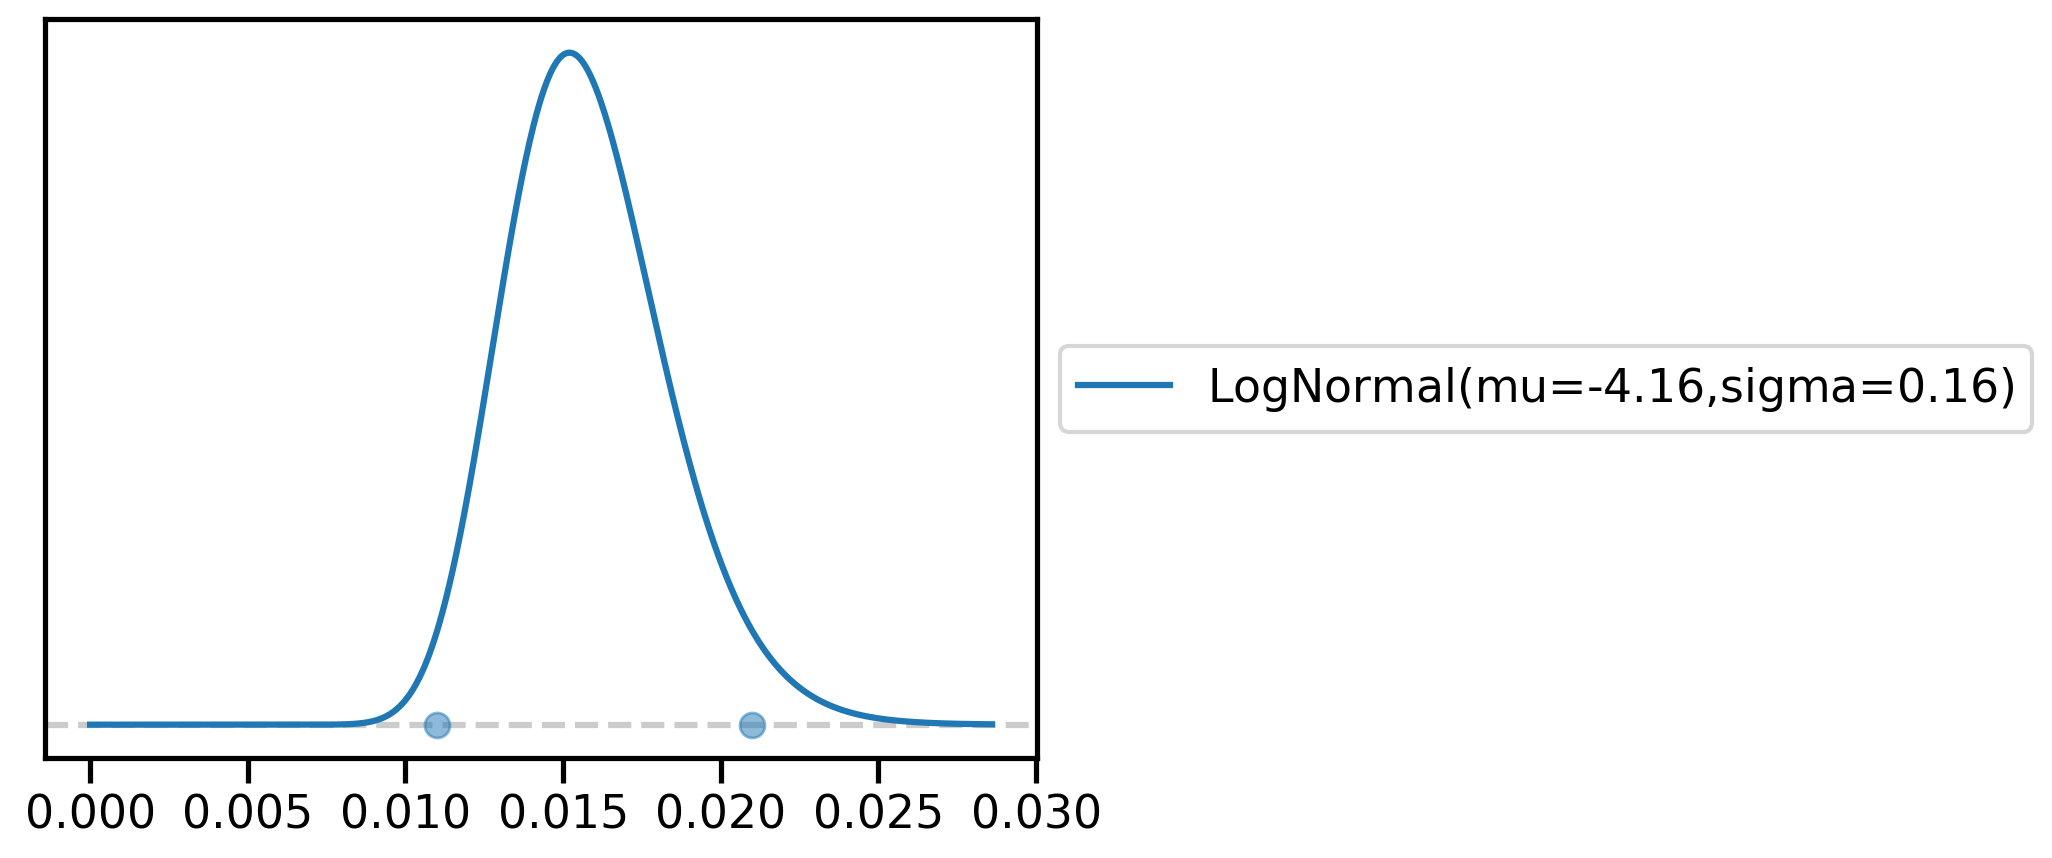

In [15]:
pz.maxent(pz.LogNormal(), 0.011, 0.021, 0.95);

The initial population size we can set to a log-normal distribution such that 95% of the distribution is within half or double of the real initial value.

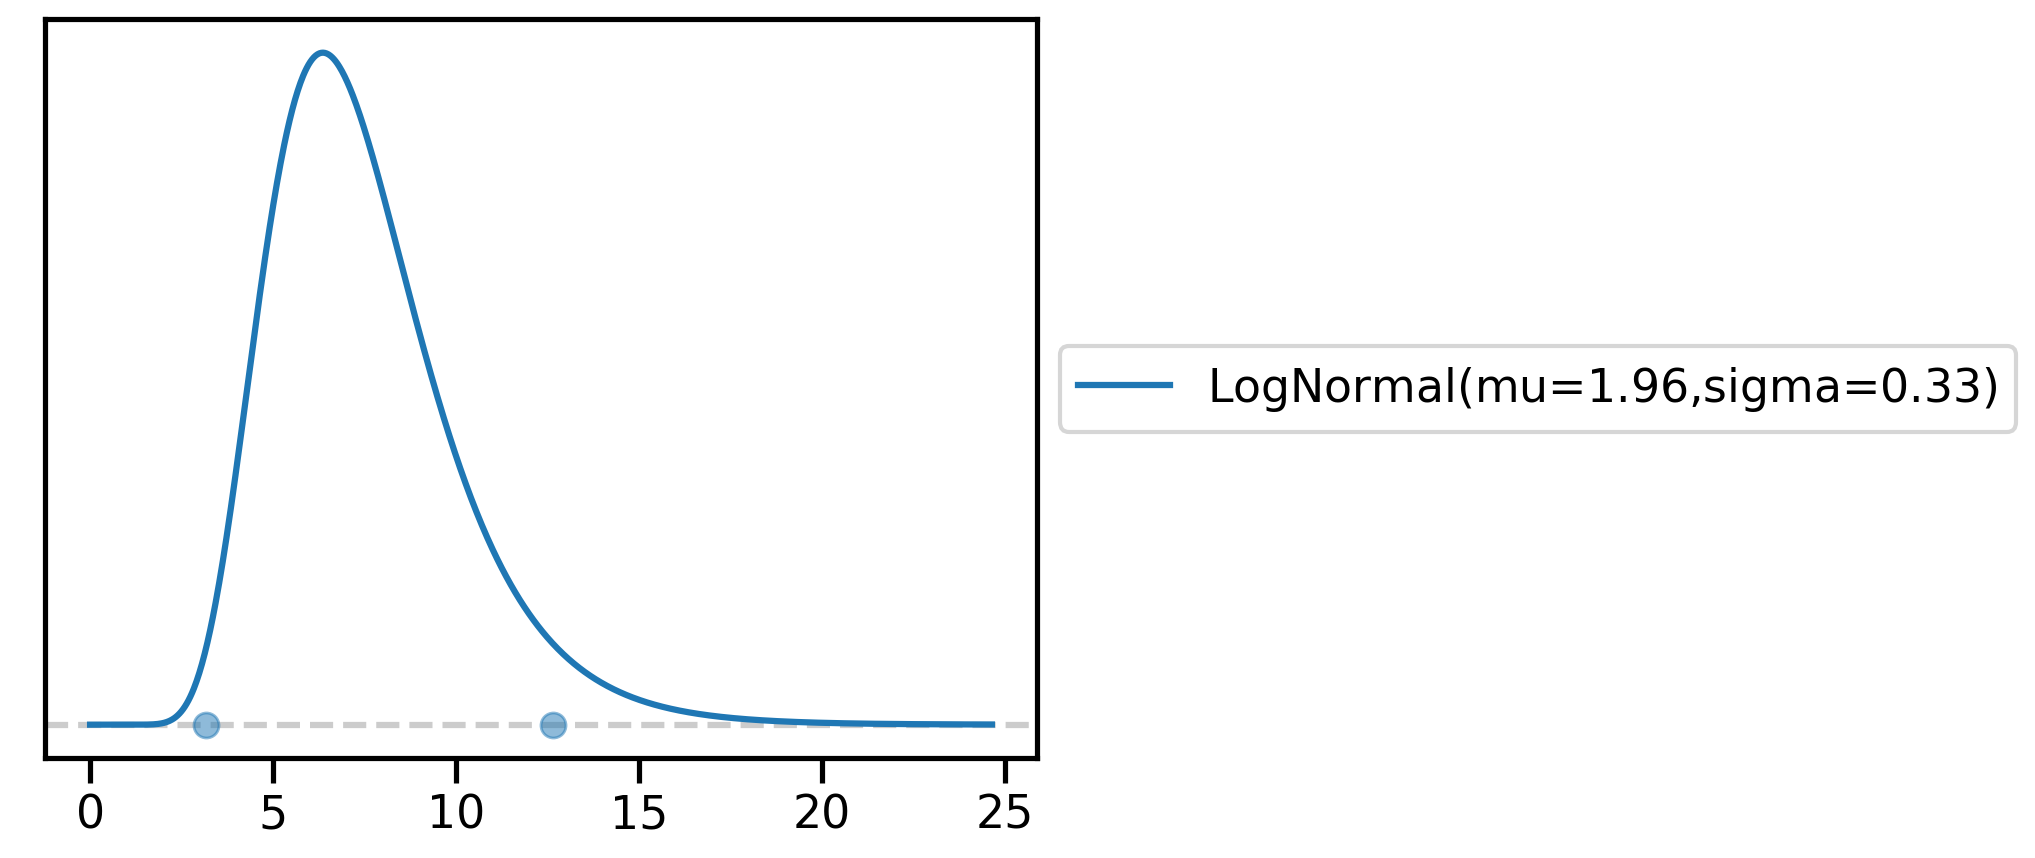

In [20]:
pz.maxent(pz.LogNormal(), y[0]/2, y[0]*2, 0.95);

Lastly, at the log scale the data does not seem very noisy, so we can use an exponential distribution, say with parameter 0.1; PreliZ can be used to visualize this prior and test different options.

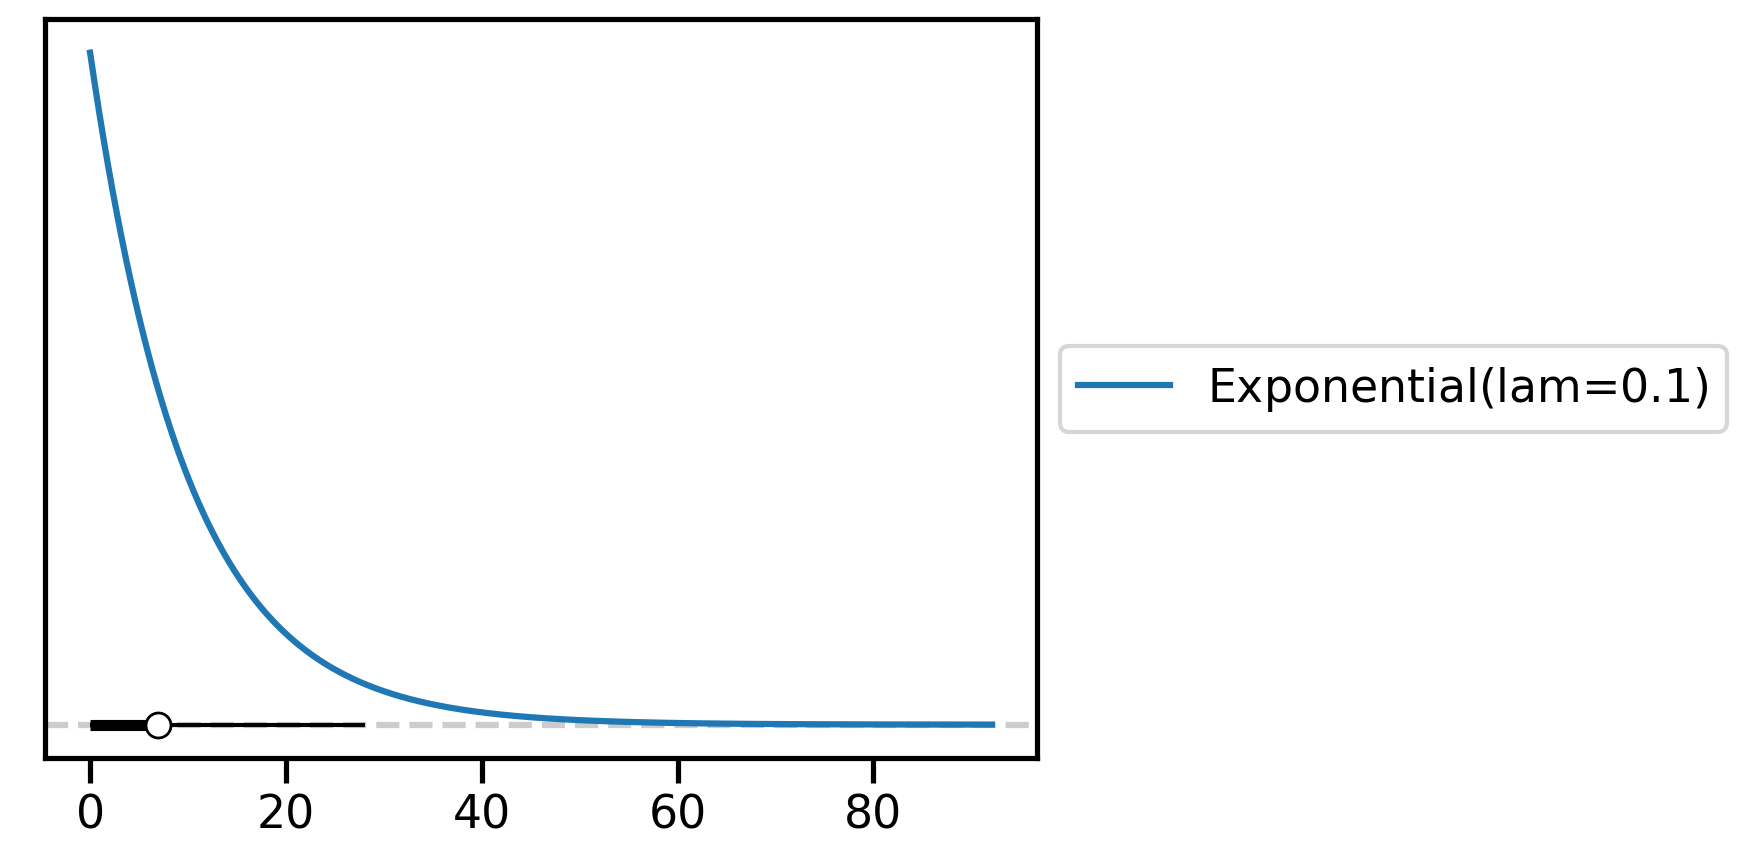

In [21]:
pz.Exponential(0.1).plot_pdf(pointinterval=True);

So overall our priors are:
$$
r \sim LogNormal(\mu=-4.16, \sigma=0.16)
\\
log(y_0) \sim LogNormal(\mu=1.96, \sigma=0.33)
\\ 
\sigma \sim \mathit{Exp}(0.1)
$$

## PyMC

We can infer linear models with PyMC, but there is also a high-level library for this (i.e., like statsmodels), called [bambi](https://bambinos.github.io/bambi/main/index.html).

In [11]:
import pymc as pm
import arviz as az

print("PyMC", pm.__version__)
print("Arviz", az.__version__)

PyMC 5.0.2
Arviz 0.15.1


In [22]:
model = pm.Model()
with model:
    r_ = pm.LogNormal('r', mu=-4.16, sigma=0.16)
    y0_ = pm.LogNormal('y0', mu=1.96, sigma=0.33)
    σ_ = pm.Exponential('σ', lam=0.1)
    y_obs = pm.Normal("y", mu=r_ * t + y0_, sigma=σ_, observed=y)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, y0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


In [41]:
az.to_netcdf(idata, 'idata_exponential_growth.nc')

'idata_exponential_growth.nc'

In [51]:
idata = az.from_netcdf('idata_exponential_growth.nc')

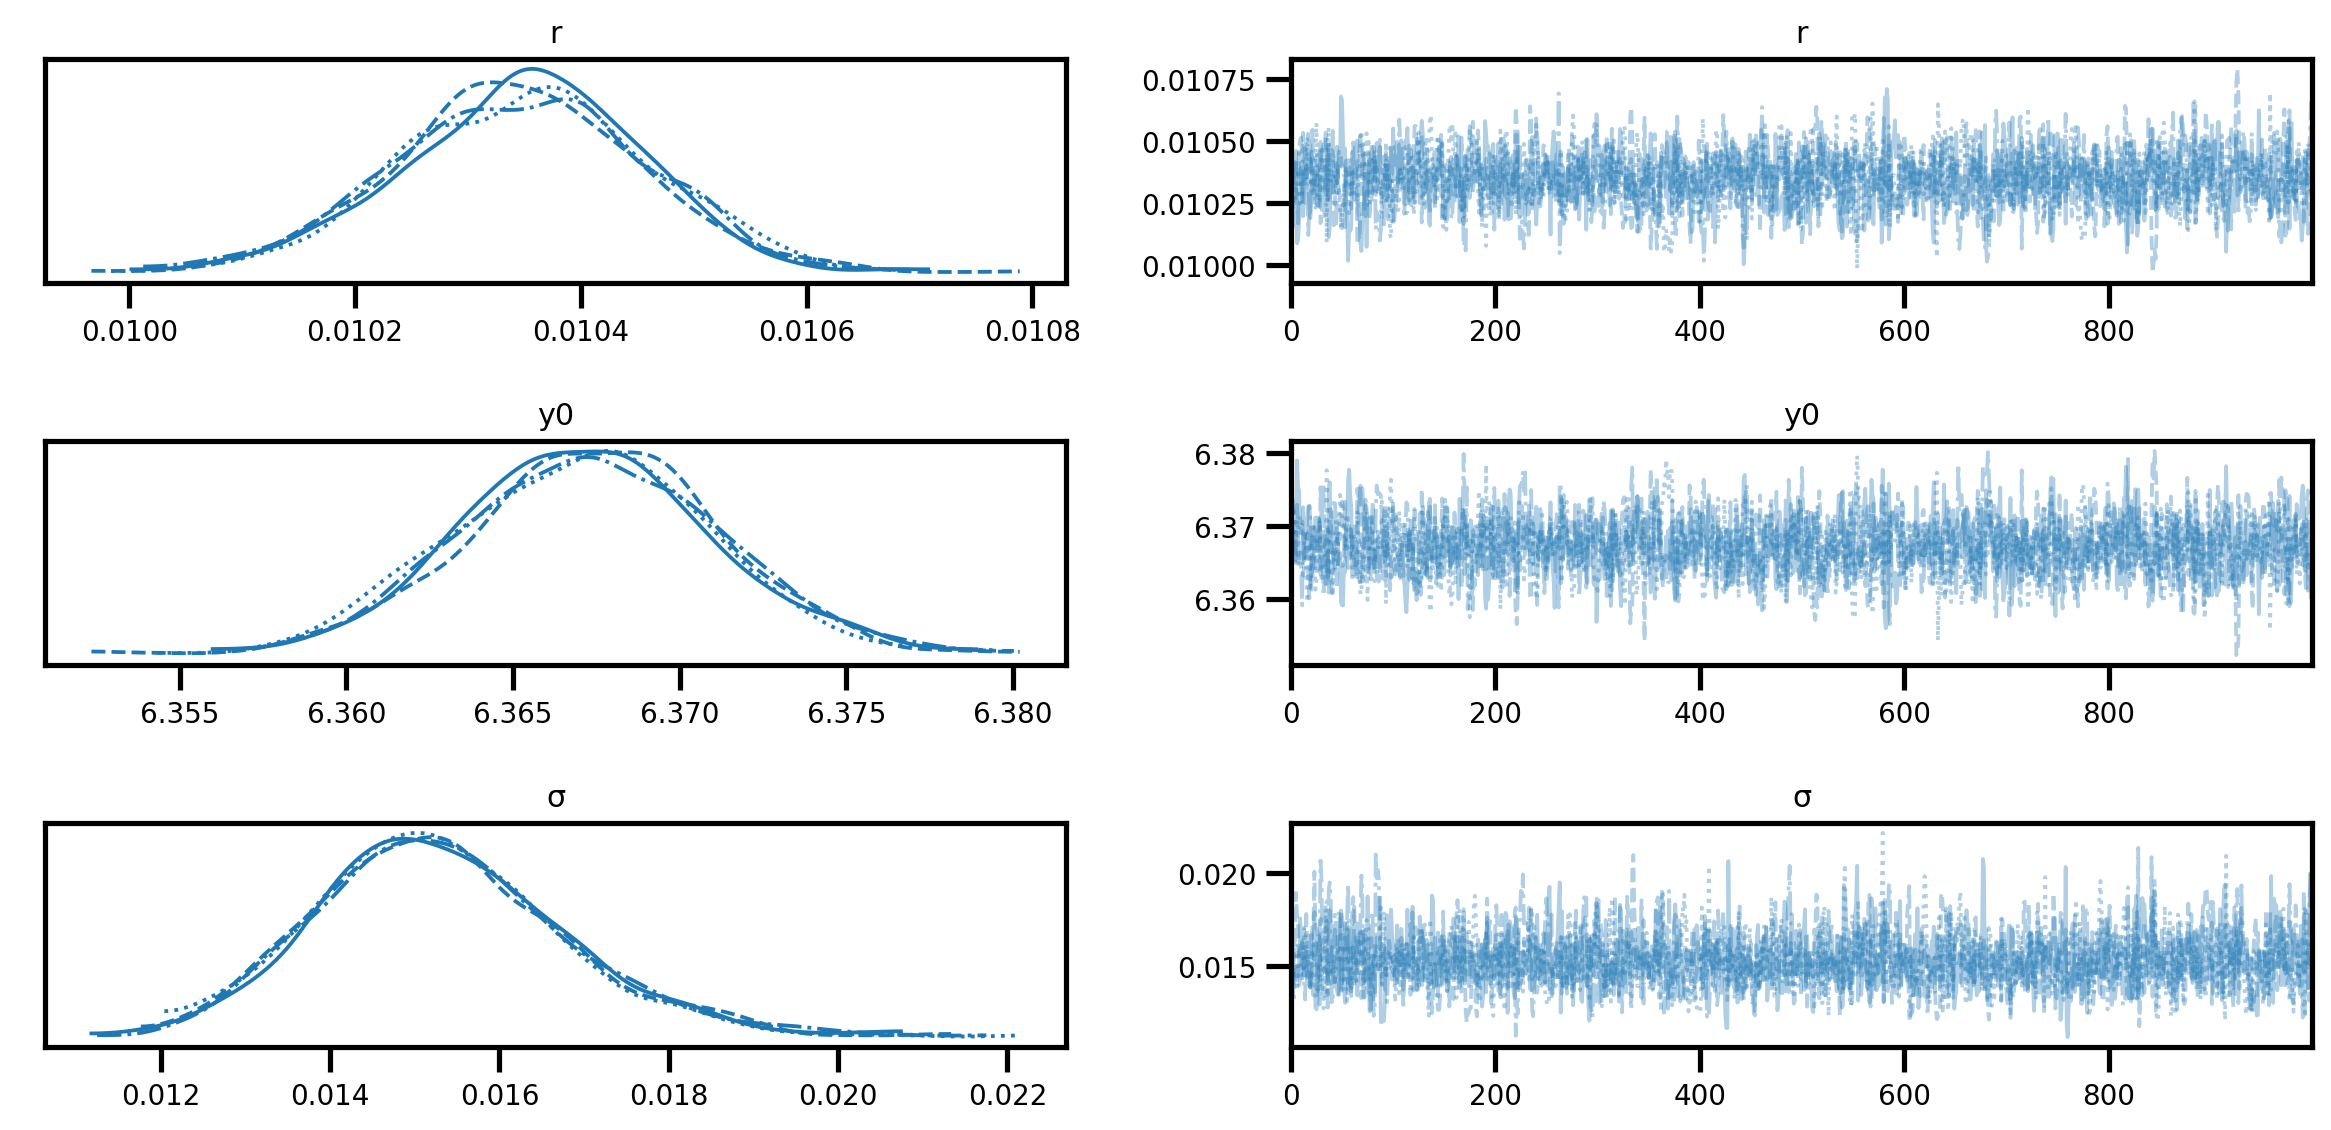

In [52]:
az.plot_trace(idata)
plt.tight_layout()

In [53]:
isummary = az.summary(idata)
θ_bayes = isummary['mean'].values
isummary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.010,0.000,0.010,0.011,0.0,0.0,1606.0,1744.0,1.0
y0,6.367,0.004,6.360,6.375,0.0,0.0,1693.0,1741.0,1.0
σ,0.015,0.001,0.013,0.018,0.0,0.0,2179.0,2219.0,1.0


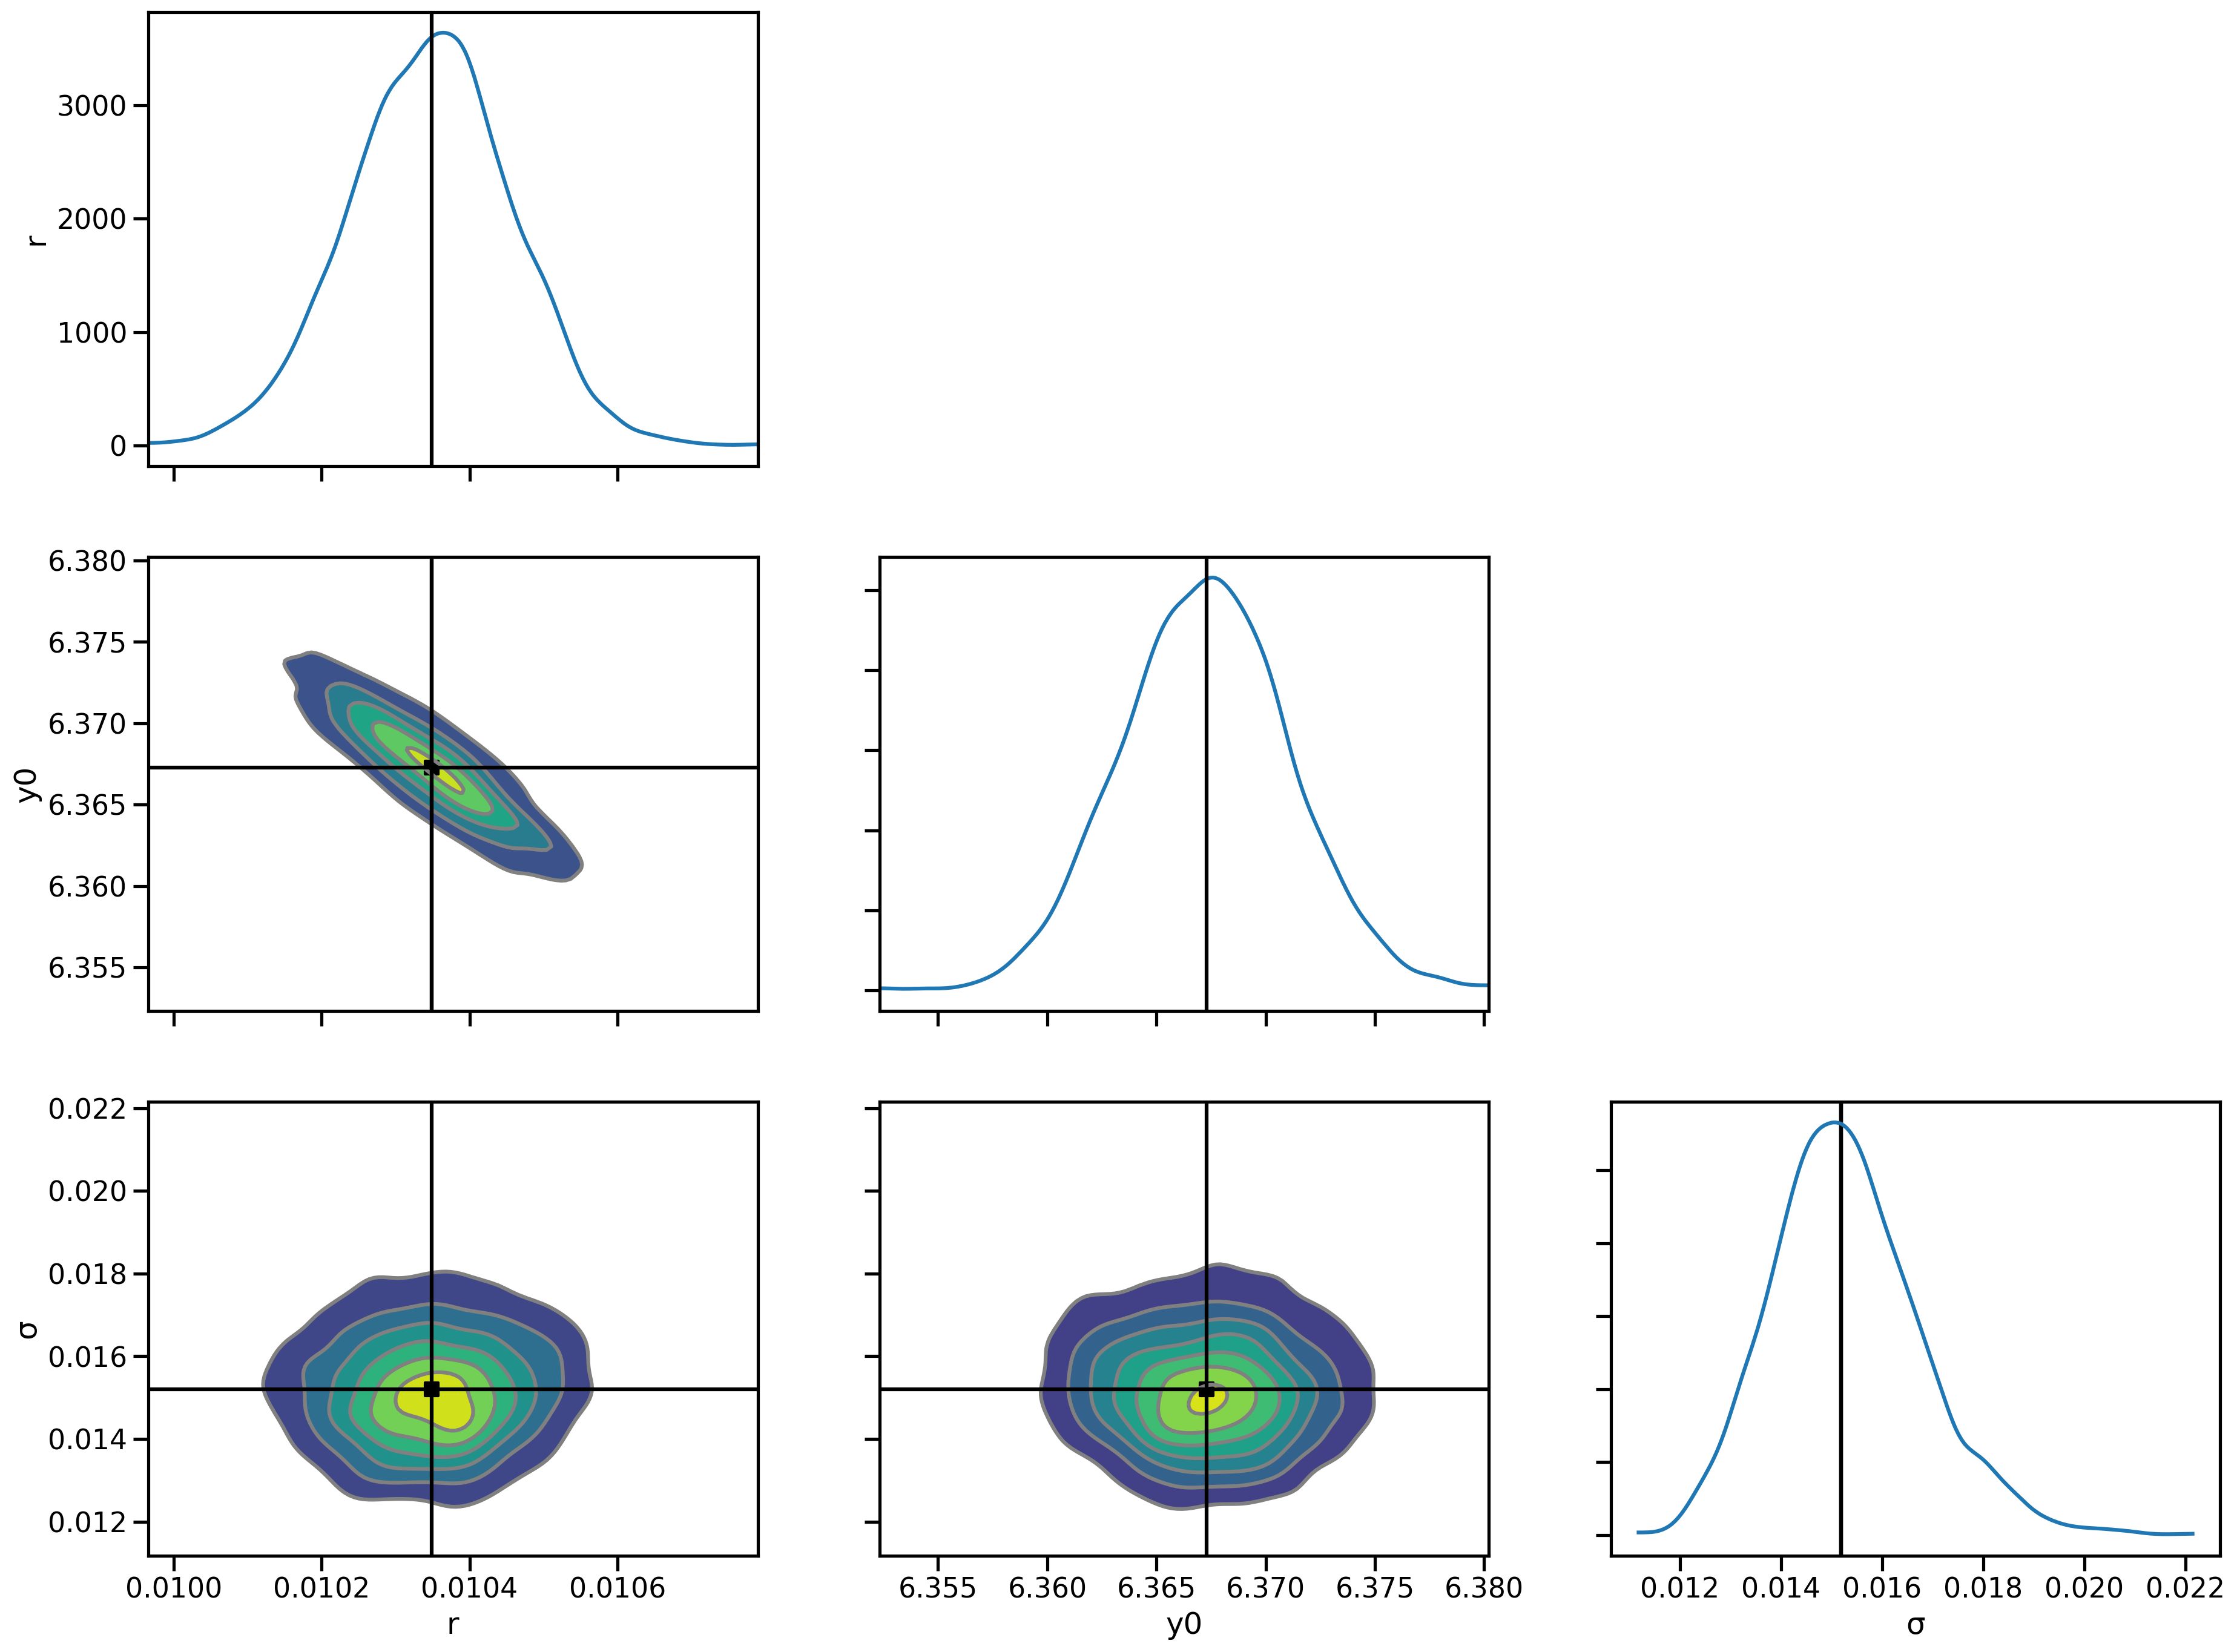

In [54]:
az.plot_pair(idata,
    kind='kde', 
    marginals=True, 
    point_estimate='median'
);

## Posterior predictive plots

One advantage of sampling from the poterior is that we can use these samples to plot a posterior predictive plot.

Here, we plot the Bayesian estimate in red, but also add lines for 100 samples from the posterior distribution of the model parameters, to plot the dispersion of prediction lines.

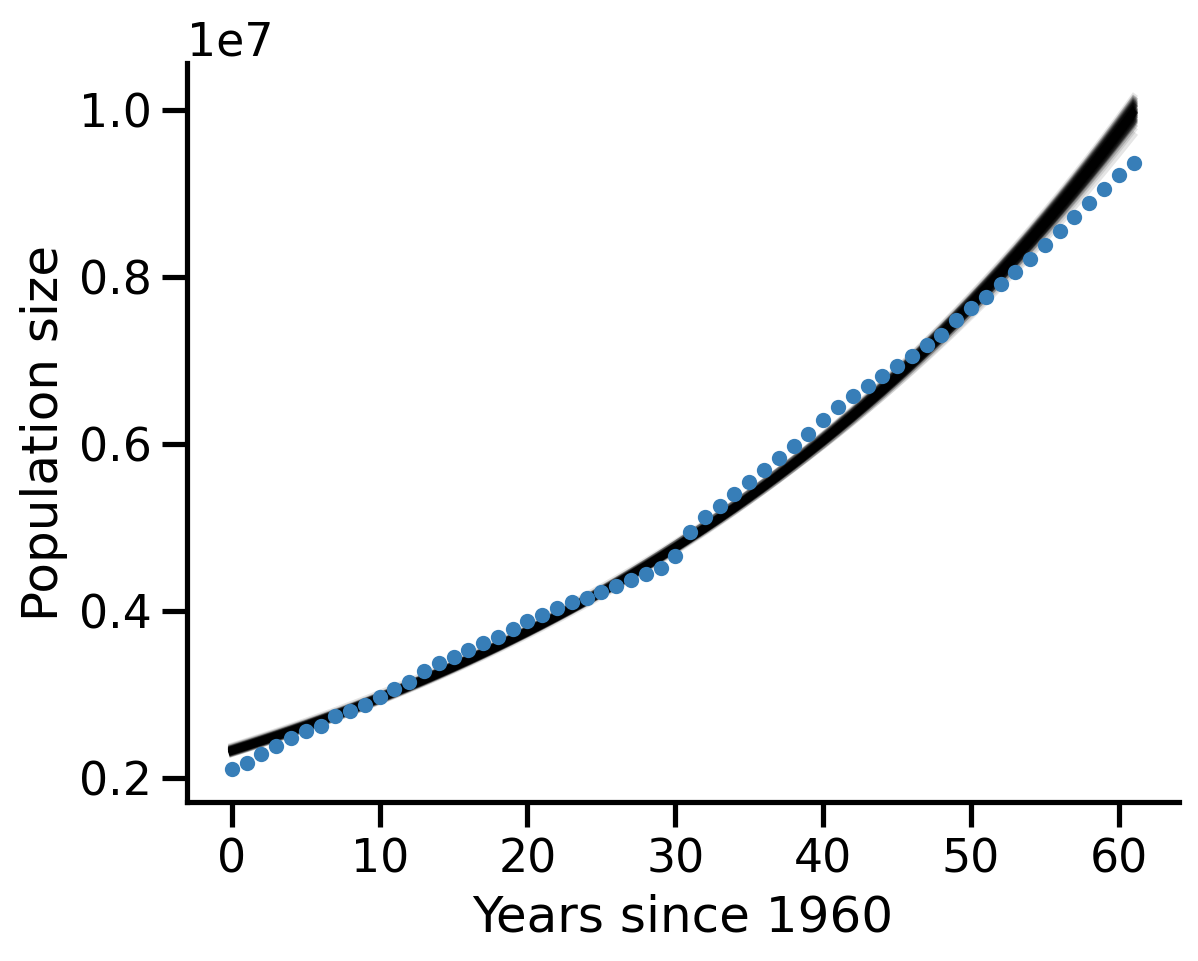

In [56]:
# posterior predictions
samples = az.extract(idata, num_samples=100, rng=0).to_dataframe() # get 100 samples from posterior into a DataFrame
r_ = samples['r'].values # np array
y0_ = samples['y0'].values # np array
t_ = t.reshape((-1,1)) # reshape allows us to do the 100 x 62 computations is one line
yhat = r_ * t_ + y0_ 
plt.plot(t, 10**yhat, '-k', alpha=0.1)

# data
plt.plot(t, 10**y, '.', color=blue)

plt.xlabel('Years since 1960')
plt.ylabel('Population size')
sns.despine()

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [_Models in Population Biology_](https://modelpopbiol.yoavram.com/) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.